In [7]:
import numpy as np
import pandas as pd
from scipy import spatial
from scipy import signal
import scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import string
import numpy as np
import random
from sklearn.metrics import classification_report,accuracy_score,balanced_accuracy_score
from sklearn.decomposition import PCA
from tqdm import tqdm

# 1. TEXT CLASSIFICATION: IMDB data

# Load data

In [8]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    try: torch.manual_seed(seed_value)
    except: pass

seed_everything(7)

data    = pd.read_csv("imdb.csv",index_col=0)
X_train,X_test,y_train,y_test = train_test_split(data["LongPlot"],data["Genre"],stratify = data["Genre"])

FileNotFoundError: [Errno 2] No such file or directory: 'imdb.csv'

#### Preprocessing

In [3]:
categories      = ["Family", "Romance", "Sci-Fi", "Thriller"]
n_classes       = len(categories)
train_texts     = list(X_train.values)
test_texts      = list(X_test.values)
train_labels_genre=list(y_train.values)
test_labels_genre=list(y_test.values)
le = preprocessing.LabelEncoder()
le.fit(categories)
train_labels = le.transform(train_labels_genre)
test_labels = le.transform(test_labels_genre)
print("Class balances:")
for i,c in enumerate(categories):
    print(c,np.mean(train_labels==i))

Class balances:
Family 0.14380865879503482
Romance 0.34332425068119893
Sci-Fi 0.12352406902815623
Thriller 0.38934302149561006


# GloVe

#### Cleaning the text for GloVe:

In [4]:
def clean(text):
    return text.translate(str.maketrans('', '', string.punctuation)).lower()

#### Converting the words to vectors and take the average for each movie plot

In [5]:
raw_glove = [line.split() for line in open("glove.6B.100d.txt",encoding = 'utf8').read().split("\n")]

In [6]:
dict_glove = {line[0]:np.array(line[1:]).astype(np.float) for line in raw_glove[:-1]}

In [7]:
def calc_z_glove(text):
    text = clean(text).split()
    N = len(text)
    z_glove = np.zeros_like(dict_glove["the"])
    
    for word in text:
        try:
            z_glove += dict_glove[word]
        except KeyError:
            N -= 1
            
    return z_glove/N

train_z_glove = np.array([calc_z_glove(text) for text in train_texts])
test_z_glove  = np.array([calc_z_glove(text) for text in test_texts ])

# PCA of movie plots

In [8]:
#standardize data
train_z_glove_mean = np.mean(train_z_glove,axis = 0)
train_z_glove_std  = np.std(train_z_glove,axis = 0, ddof = 1)
train_z_glove_bar = (train_z_glove-train_z_glove_mean)/train_z_glove_std

def standardize(data):
    return (data - train_z_glove_mean)/train_z_glove_std


#run pca
pca_glove = PCA()
pca_glove.fit(train_z_glove_bar)

PCA()

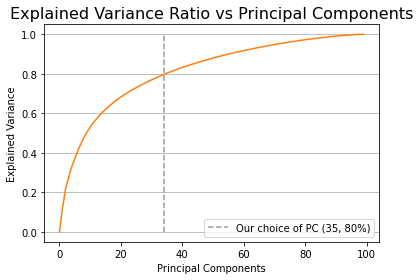

35 0.7968905275747802


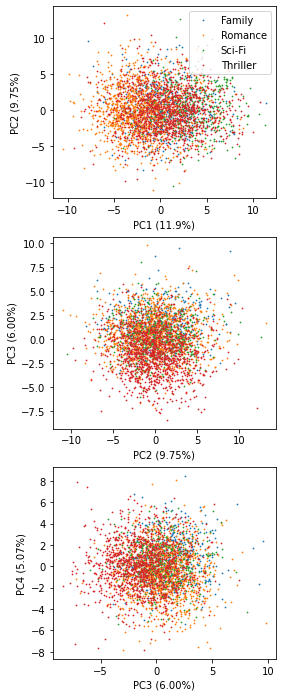

(3303, 100)


In [9]:
#calculate explained variance
exp_var = pca_glove.explained_variance_
exp_var_rat = [np.sum(exp_var[:i]) for i, _ in enumerate(exp_var)]
exp_var_rat/=exp_var_rat[-1]
ours_choice_of_PC = np.argmin([abs(val - 0.8) for val in exp_var_rat])
#plot
plt.title("Explained Variance Ratio vs Principal Components",fontsize=16)
plt.plot([ours_choice_of_PC]*2,[0,1],"--",color="#999999",label="Our choice of PC (35, 80%)")
plt.plot(exp_var_rat, "-C1")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance")
plt.grid(axis='y',which='major')
plt.legend()
plt.show()

print(ours_choice_of_PC + 1, exp_var_rat[ours_choice_of_PC])

#project training data onto pca basis
train_z_proj = ( pca_glove.components_ @ train_z_glove_bar.T ).T

#plot principal components against each other
fig, axs = plt.subplots(3, 1, figsize=(4,12))

#plt.suptitle("Training data projected on PCA")
for comp_start, ax in enumerate(axs.flatten()):
    for i in range(4):
        index = train_labels == i
        xs = train_z_proj[index,comp_start]
        ys = train_z_proj[index,comp_start + 1]
        ax.plot(xs,ys,".", markersize=1.5, label=categories[i])
        
    ax.set_xlabel(f"PC{comp_start+1} ({str(exp_var[comp_start])[:4]}%)")
    ax.set_ylabel(f"PC{comp_start+2} ({str(exp_var[comp_start + 1])[:4]}%)")
      
    if comp_start == 0: ax.legend()

plt.show()

print(train_z_proj.shape)

# Classify genres based on the first n principal components of glove vectors

In [10]:
def project(z_glove, n_components):
    return pca_glove.components_[:n_components] @ standardize(z_glove)



In [11]:
#create the baysian classifier
prior = [np.mean(train_labels==i) for i in range(4)]

train_z_proj_means = np.zeros((4, 100))
train_z_proj_covs  = np.zeros((4,100,100))
for i in range(4):
    index = train_labels == i
    train_z_proj_means[i] = np.mean(train_z_proj[index], axis = 0)
    train_z_proj_covs[i]  = np.cov(train_z_proj[index].T)

from scipy.stats import multivariate_normal
normal_prob_density = [multivariate_normal(mean=train_z_proj_means[i], cov=train_z_proj_covs[i]) for i in range(4)]


def get_bayesian(text,n_components):
    z_glove = calc_z_glove(text)
   
    posts = np.zeros(4)
    for i in range(4):
        
        z_proj = np.copy(train_z_proj_means[i])
        z_proj[:n_components] = project(z_glove, n_components)

        
        # (no evidence, as it is not needed to find max)
        likelihood = normal_prob_density[i].pdf(z_proj)
        posts[i] = likelihood * prior[i]
    
    return posts/posts.sum()


def bayesian_classify(text,n_components):
    posts = get_bayesian(text,n_components)
    return np.argmax(posts)




In [12]:
#print(cat_means.shape)
split = 5
step  = 1
n_components = np.hstack((np.arange(1,split),np.arange(split,100,step),[100])).astype(int)
correct_classifications_bayesian = np.zeros_like(n_components).astype(float)



for j, n_comps in enumerate(tqdm(n_components)):
    #print(n_comps)
    correct_bayesian = 0
    for text, label in zip(test_texts,test_labels):
        correct_bayesian += bayesian_classify(text,n_comps) == label

    correct_classifications_bayesian[j] = correct_bayesian/len(test_texts)



100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


In [13]:
training_bayesian = np.zeros_like(n_components).astype(float)

for j, n_comps in enumerate(tqdm(n_components)):
    #print(n_comps)
    correct_bayesian = 0
    for text, label in zip(train_texts,train_labels):
        correct_bayesian += bayesian_classify(text,n_comps) == label

    training_bayesian[j] = correct_bayesian/len(train_texts)

100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


35 0.5916515426497277
35 0.6905843172873145


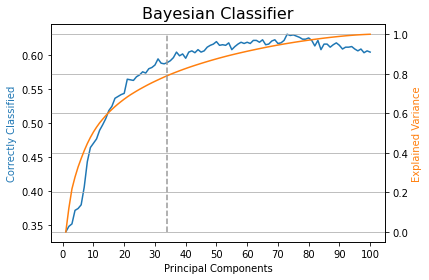

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.grid(which='major')
ax1.plot(n_components, correct_classifications_bayesian, "-C0", label="Bayesian Classifier")
ax2.plot(np.arange(1,101), exp_var_rat, "-C1", label="Explained Variance")
plt.plot([ours_choice_of_PC]*2,[0,1],"--",color="#999999",label="Our choice of PC (35, 80%)")
print(n_components[34],correct_classifications_bayesian[34])
print(n_components[34],training_bayesian[34])
ax1.set_xlabel("Principal Components")
ax1.set_ylabel("Correctly Classified", color="C0")
ax2.set_ylabel("Explained Variance", color="C1")
plt.title("Bayesian Classifier",fontsize=16)
plt.xticks(np.arange(0,101,10))

plt.show()

# FastText Classification using 3-gram embeddings

In [15]:
#########################################################################################################
# Adapted from: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
# And https://pytorch.org/text/_modules/torchtext/datasets/text_classification.html
# And with inspiration from original adaptation by (presumably) Jonathan Foldager and (presumably) Hiba Nassar
#########################################################################################################

import numpy as np
import random
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import time
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import TextClassificationDataset
from torchtext.vocab import Vocab
from torchtext.vocab import build_vocab_from_iterator

#####################################################################################################################
# Auxilary functions
#####################################################################################################################

# Basic tokenizer, lowers text; splits by whitespace and special characters
tokenizer = get_tokenizer("basic_english")

def token_iterator(texts, ngrams):
    """
    Generator function, should be used to create a generator object
    of ngrams for each token in a given text
    """

    for text in texts:
        tokens = tokenizer(text)

        # Notice the yield keyword, rather than terminate the function like 'return' would, it 'yields' the object to a generator object
        yield ngrams_iterator(tokens, ngrams)


def construct_vocab(texts, ngrams: int):
    """
    Builds a torchtext.vocab.Vocab object from an iterable of texts
    Notice it also uses the token_iterator function, specified above above
    Basically a vocab is a like an ordered dictionary that holds occurance frequences of tokens
    So vocab[token] returns the number of occurences of that token
    Additionally, this token can be gated by frequency
    """
    vocab = build_vocab_from_iterator(token_iterator(texts, ngrams))
    return vocab


def text_to_tensor(text, vocab, ngrams):
    """
    Takes a single text and spits out a token vector (tensor)
    Possibly removes speical characters
    """

    # Get all tokens of a text
    tokens = ngrams_iterator(tokenizer(text), ngrams=ngrams)

    # Create a list, of simple token ids IFF the token is contained within the vocab
    # Perhaps wrong here, maybe Vocab.specials is the correct way to go
    token_ids = list(filter(lambda x: x is not Vocab.UNK, [vocab[token] for token in tokens]))

    # Create the glorious torch tensor from the tokens
    tokens = torch.tensor(token_ids)
    return tokens


def make_torchdataset(vocab, texts, labels, ngrams):
    # Tensonize each text in the texts dataset
    tokens = [text_to_tensor(text, vocab, ngrams) for text in tqdm(texts)]
    # Get label, token pairs
    # Remember labels are most likely a list whereas tokens are a list of a lists
    pairs = list(zip(labels, tokens))
    return TextClassificationDataset(vocab, pairs, set(labels))

def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

#####################################################################################################################
# Model
#####################################################################################################################


class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

#####################################################################################################################
# FastText
#####################################################################################################################


class FastText(object):

    def __init__(self, texts, labels, embed_dim, ngrams=3, num_epochs=0, seed=0):

        # set seed
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)


        self.texts = texts
        self.labels = labels
        self.embed_dim = embed_dim
        self.ngrams = ngrams

        # construct vocab
        print('Constructing vocabulary...')
        self.vocab = construct_vocab(texts, ngrams)
        self.vocab_size = len(self.vocab)

        # prepare dataset
        print('Preparing dataset...')
        self.train_dataset = make_torchdataset(self.vocab, texts, labels, ngrams)
        self.num_classes = len(self.train_dataset.get_labels())

        # prepare device ref and model
        self.device = torch.device("cpu")
        self.model = TextClassificationModel(self.vocab_size, self.embed_dim, self.num_classes).to(self.device)

        # loss function & optimization
        self.results = [].copy()
        self.epochs = 0
        self.criterion = torch.nn.CrossEntropyLoss().to(self.device)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=4.0)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
        self.batch_size = 16

        self.tokenizer = get_tokenizer("basic_english")
        self.ngrams = ngrams



        if num_epochs > 0:
            print('Training model...')
            self.train(self.train_dataset, num_epochs)


    def train_step(self, sub_train_):

        # Train the model
        train_loss = 0
        train_acc = 0
        data = DataLoader(sub_train_, batch_size=self.batch_size, shuffle=True, collate_fn=generate_batch)
        for i, (text, offsets, cls) in enumerate(data):
            self.optimizer.zero_grad()
            text, offsets, cls = text.to(self.device), offsets.to(self.device), cls.to(self.device)
            output = self.model(text, offsets)
            loss = self.criterion(output, cls)
            train_loss += loss.item()
            loss.backward()
            self.optimizer.step()
            train_acc += (output.argmax(1) == cls).sum().item()

        # Adjust the learning rate
        self.scheduler.step()

        return train_loss / len(sub_train_),  train_acc / len(sub_train_)

    def compute_loss(self, data_):
        loss = 0
        acc = 0
        data = DataLoader(data_, batch_size=self.batch_size, collate_fn=generate_batch)
        for text, offsets, cls in data:
            text, offsets, cls = text.to(self.device), offsets.to(self.device), cls.to(self.device)
            with torch.no_grad():
                output = self.model(text, offsets)
                loss = self.criterion(output, cls)
                loss += loss.item()
                acc += (output.argmax(1) == cls).sum().item()

        return loss / len(data_), acc / len(data_)

    def train(self, train_dataset, n_epochs=5):
        
        min_valid_loss = float('inf')

        for epoch in range(n_epochs):
            self.epochs += 1
            start_time = time.time()
            train_loss, train_acc  = self.train_step(train_dataset)

            secs = int(time.time() - start_time)
            mins = secs / 60
            secs = secs % 60
            
            test_results = [self.predict(text) for text in test_texts]
            test_acc = np.mean([test_results == test_labels])
            
            print('Epoch: %d' % (self.epochs), " | time in %d minutes, %d seconds" % (mins, secs))
            print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train), {test_acc * 100:.1f}%(test)')
            
            self.results.append([self.epochs,train_acc,test_acc,test_results])
            
            
        return self.results

    def predict(self, text_, return_prob=False):

        with torch.no_grad():
            text = text_to_tensor(text_, self.vocab, self.ngrams)
            output = self.model(text, torch.tensor([0]))

            if return_prob:
                return F.softmax(output, 1).detach().numpy()
            else:
                return output.argmax(1).item()

    def get_text_embedding(self, text_):
        with torch.no_grad():
            text = text_to_tensor(text_, self.vocab, self.ngrams)
            return self.model.embedding(text, offsets=torch.LongTensor([0])).detach().numpy()

    def word_in_vocab(self, word):
        return word in self.vocab.stoi





In [16]:
# Usage example:
seed_everything(7)

model = FastText(train_texts,train_labels,embed_dim=100)

1102lines [00:00, 5572.24lines/s]Constructing vocabulary...
3303lines [00:00, 4946.34lines/s]
100%|██████████| 3303/3303 [00:01<00:00, 2341.73it/s]


# Classification on test set

In [17]:
results_raw = model.train(model.train_dataset, 30)
results = np.array([res[:3] for res in results_raw])
predictions = [[res[0],res[3]] for res in results_raw]

Epoch: 1  | time in 0 minutes, 4 seconds
	Loss: 0.0848(train)	|	Acc: 37.5%(train), 38.9%(test)
Epoch: 2  | time in 0 minutes, 4 seconds
	Loss: 0.0775(train)	|	Acc: 46.4%(train), 49.4%(test)
Epoch: 3  | time in 0 minutes, 4 seconds
	Loss: 0.0709(train)	|	Acc: 50.9%(train), 49.1%(test)
Epoch: 4  | time in 0 minutes, 4 seconds
	Loss: 0.0649(train)	|	Acc: 57.1%(train), 48.7%(test)
Epoch: 5  | time in 0 minutes, 4 seconds
	Loss: 0.0570(train)	|	Acc: 64.8%(train), 55.9%(test)
Epoch: 6  | time in 0 minutes, 4 seconds
	Loss: 0.0504(train)	|	Acc: 70.1%(train), 48.3%(test)
Epoch: 7  | time in 0 minutes, 4 seconds
	Loss: 0.0443(train)	|	Acc: 75.4%(train), 43.8%(test)
Epoch: 8  | time in 0 minutes, 4 seconds
	Loss: 0.0379(train)	|	Acc: 80.7%(train), 51.9%(test)
Epoch: 9  | time in 0 minutes, 4 seconds
	Loss: 0.0330(train)	|	Acc: 84.7%(train), 49.8%(test)
Epoch: 10  | time in 0 minutes, 4 seconds
	Loss: 0.0288(train)	|	Acc: 88.5%(train), 53.0%(test)
Epoch: 11  | time in 0 minutes, 4 seconds
	Loss: 

30.0 0.9903118377232819
30.0 0.5780399274047187


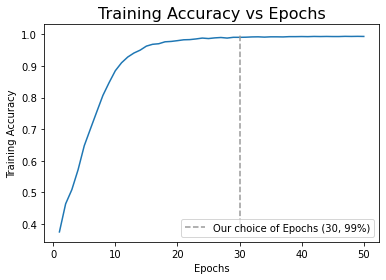

In [18]:
plt.plot(results[:,0],results[:,1])
plt.title("Training Accuracy vs Epochs",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
ours_choice_of_epoch = 29
print(results[:,0][ours_choice_of_epoch],results[:,1][ours_choice_of_epoch])
print(results[:,0][ours_choice_of_epoch],results[:,2][ours_choice_of_epoch])
plt.plot([30]*2,[results[:,1][0],1],"--",color="#999999",label="Our choice of Epochs (30, 99%)")
#plt.plot(results[:,0],results[:,2])
plt.legend(loc=4)
plt.show()

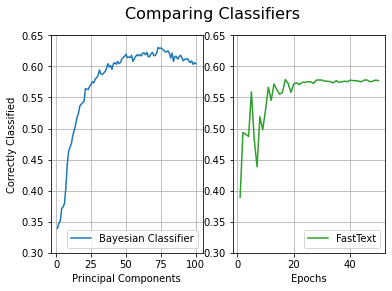

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)
how_many1, how_many2 = 100, 50
ax1.plot(n_components[:how_many1], correct_classifications_bayesian[:how_many1], label="Bayesian Classifier")
ax2.plot(results[:,0][:how_many2], results[:,2][:how_many2], "C2", label="FastText")

fig.suptitle("Comparing Classifiers", fontsize=16)
ax1.grid(which='major')
ax2.grid(which='major')
ax1.legend(loc=4)
ax2.legend(loc=4)
ax1.set_xlabel("Principal Components")
ax2.set_xlabel("Epochs")
ax1.set_ylabel("Correctly Classified")
#ax2.set_ylabel("Correctly Classified")
ax1.set_ylim([.30,.65])
ax2.set_ylim([.30,.65])

plt.show()

# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()

# ax1.plot(n_components, correct_classifications_bayesian, "-C0", label="Bayesian Classifier")
# ax2.plot(results[:,0],results[:,2], "-C2", label="FastText")


# ax1.set_xlabel("Principal Components", color="C0")
# ax2.set_xlabel("Epochs", color="C2")
# ax1.set_ylabel("Correctly Classified")
# plt.title("Comparing Classifiers")
# plt.xticks(np.arange(0,101,10))
# plt.grid(which='major')
# ax1.legend()
# plt.show()

### Hvorfor er resultaterne så dårlige? bruger vi predict forkert?

# Confusion matrix

C:\Users\niels\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


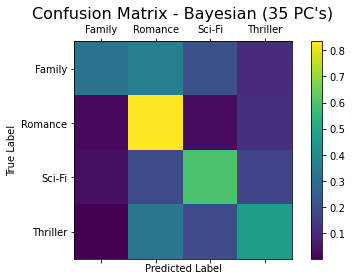

C:\Users\niels\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
(50, 2)
1102
30


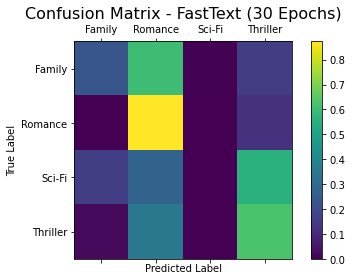

In [20]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

labels = list(range(4))

preds = [bayesian_classify(text, ours_choice_of_PC) for text in test_texts]

cm = confusion_matrix(test_labels, preds, labels,normalize="true")
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.title("Confusion Matrix - Bayesian (35 PC's)",fontsize=16)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_xticks(labels)
ax.set_yticks(labels)
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)
plt.tight_layout()
plt.show()



print(np.shape(predictions))
print(len(predictions[29][1]))
print(predictions[29][0])

labels = list(range(4))

preds = predictions

cm = confusion_matrix(test_labels, predictions[29][1], labels,normalize="true")
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.title("Confusion Matrix - FastText (30 Epochs)",fontsize=16)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_xticks(labels)
ax.set_yticks(labels)
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)
plt.tight_layout()
plt.show()

# PCA on FastText embeddings

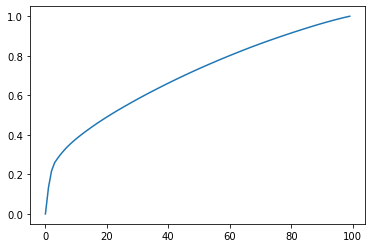

In [21]:
train_z_fast_text = np.array([model.get_text_embedding(text)[0] for text in train_texts])
test_z_fast_text  = np.array([model.get_text_embedding(text)[0] for text in test_texts ])


train_z_fast_text_mean = np.mean(train_z_fast_text, axis = 0)
train_z_fast_text_std  =  np.std(train_z_fast_text, axis = 0, ddof = 1)

def standardize_fast_text(z):
    return (z-train_z_fast_text_mean)/train_z_fast_text_std

train_z_fast_text_bar  = standardize_fast_text(train_z_fast_text)
pca_fast_text = PCA()
pca_fast_text.fit(train_z_fast_text_bar)

#calculate explained variance
exp_var_fast_text = pca_fast_text.explained_variance_
exp_var_fast_text_rat = [np.sum(exp_var_fast_text[:i]) for i, _ in enumerate(exp_var_fast_text)]
exp_var_fast_text_rat/=exp_var_fast_text_rat[-1]
#plot
plt.plot(exp_var_fast_text_rat)
plt.show()

#project training data onto pca basis
train_z_fast_text_proj = ( pca_fast_text.components_ @ train_z_fast_text_bar.T ).T

#project test data onto pca basis
test_z_fast_text_proj  = ( pca_fast_text.components_ @ standardize_fast_text(test_z_fast_text).T ).T

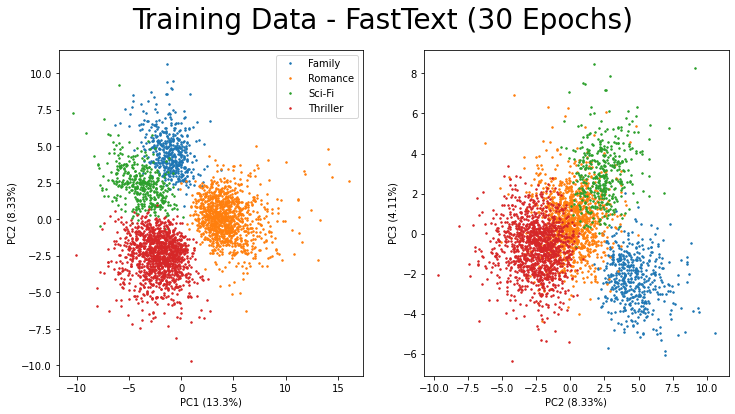

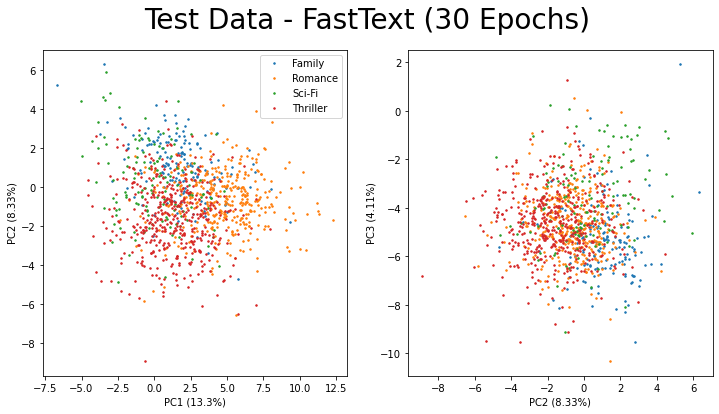

In [22]:
#plot principal components against each other
tal = 6

for whattitle, whatifs, whatews in zip(["Training Data - FastText (30 Epochs)", "Test Data - FastText (30 Epochs)"], [train_labels, test_labels], [train_z_fast_text_proj, test_z_fast_text_proj]):
    fig, axs = plt.subplots(1, 2, figsize=(2*tal,tal))

    for comp_start, ax in enumerate(axs.flatten()):
        for i in range(4):
            index = whatifs == i
            xs = whatews[index,comp_start]
            ys = whatews[index,comp_start + 1]
            ax.plot(xs,ys,".", markersize=3, label=categories[i])
        fig.suptitle(whattitle, fontsize=28)
        ax.set_xlabel(f"PC{comp_start+1} ({str(exp_var_fast_text[comp_start])[:4]}%)")
        ax.set_ylabel(f"PC{comp_start+2} ({str(exp_var_fast_text[comp_start + 1])[:4]}%)")
        
        if comp_start == 0: ax.legend()

    plt.show()

# Write your own plot and see what genre glove+PCA+classifier and FastText guess it is

In [23]:
movie_plot = "A son is sent off to his first day in college by his parents, just as they say goodbye for the last time a stranger goes up to the parents and addresses them as Mom and Dad. The stranger bears a striking resemblance to their son who just left, and is there with his wife saying good bye to their daughter. The film then is told from the son's perspective, a month into college he researches a unsolved murder on campus. He is attacked by the murderer who throws him into a basement, when he gets out he wakes up in the 1970s a week before the murder takes place. The son reasoning that he must solve the murder to return home, befriends the victim and saves her life from the murderer who is a married professor having an affair. Once the son saves her life, he finds that he cannot go home and that he has fallen in love with the victim. Cue a flashforward to the opening scene as the son now in his 50s explains everything to his parents."
#credit https://www.reddit.com/r/pitchamovie/comments/frfx7s/time_travel_romcom/

b = get_bayesian(movie_plot, np.argmax(correct_bayesian)+1)
c = model.predict(movie_plot, return_prob=True)[0]
print(categories)
print(b)
print(c)

['Family', 'Romance', 'Sci-Fi', 'Thriller']
[0.03275631 0.93970217 0.01076746 0.01677405]
[0.04730073 0.48183203 0.00224244 0.46862483]


# Optional: Do classification/regression on another variable in the dataset, such as predicting movie ratings based on year and plot.

# 2. SENTIMENT ANALYSIS: The Donald

In [24]:
from afinn import Afinn
from collections import defaultdict
sent_lexicon = defaultdict(lambda: 0, Afinn()._dict)

text = np.loadtxt("Donald.txt",dtype='str')
text_cleaned = []
for word in text:
    
    # to lower
    doc_cleaned = word.lower()
    
    #doc_cleaned = ' '.join([word for word in doc_cleaned.split() if word not in stop_words])    
    doc_cleaned = doc_cleaned.replace('.', '')
    doc_cleaned = doc_cleaned.replace(',', '')
    doc_cleaned = doc_cleaned.replace('?', '')
    doc_cleaned = doc_cleaned.replace('!', '')
    text_cleaned.append(doc_cleaned)

    

In [25]:
list_of_words = ['can', 'accept', 'hate', 'dislike', 'appreciate', 'stupid',  'love', 'like', 'enjoy', 'best', 'bad', 'worst', 'outstanding', 'food', 'politics', 'movie']
afinn = Afinn()
for word in list_of_words:
    if word in sent_lexicon:
        print('%-15s%+3.2f  %+3.2f' % (word, sent_lexicon[word], afinn.score(word)))
    else:
        print('Word "%s" not found' % word)

print(text_cleaned)

print(afinn)

Word "can" not found
accept         +1.00  +1.00
hate           -3.00  -3.00
dislike        -2.00  -2.00
appreciate     +2.00  +2.00
stupid         -2.00  -2.00
love           +3.00  +3.00
like           +2.00  +2.00
enjoy          +2.00  +2.00
best           +3.00  +3.00
bad            -3.00  -3.00
worst          -3.00  -3.00
outstanding    +5.00  +5.00
Word "food" not found
Word "politics" not found
Word "movie" not found
['chief', 'justice', 'roberts', 'president', 'carter', 'president', 'clinton', 'president', 'bush', 'president', 'obama', 'fellow', 'americans', 'and', 'people', 'of', 'the', 'world', 'thank', 'you', 'we', 'the', 'citizens', 'of', 'america', 'are', 'now', 'joined', 'in', 'a', 'great', 'national', 'effort', 'to', 'rebuild', 'our', 'country', 'and', 'restore', 'its', 'promise', 'for', 'all', 'of', 'our', 'people', 'together', 'we', 'will', 'determine', 'the', 'course', 'of', 'america', 'and', 'the', 'world', 'for', 'many', 'many', 'years', 'to', 'come', 'we', 'will', 

# Calculate window-wise sentiment and have the window size and stride as variables that can easily be changed

In [26]:
def create_signal(window_size, stride,text):
    text_scores = []
    start = 0
    while start < len(text):
        window_raw = text[start:start + window_size]
        #print(len(window_raw))
        window = " ".join(window_raw)
        #print(afinn.score(window))
        try: text_scores.append(afinn.score(window))
        except: print(middle)
        
        start += stride
    
    return text_scores

# Plot the sentiment over time

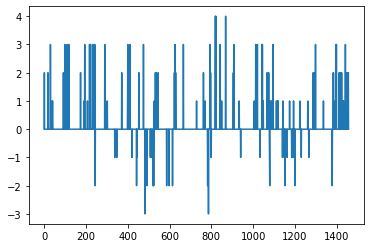

In [27]:
window_size = 1
stride = 1
sign = create_signal(window_size, stride, text_cleaned)
plt.plot(sign)
plt.show()

# Low pass filter using a smoothing filter

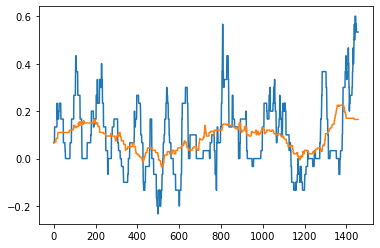

In [28]:
deg_smooth = 2
#signal_convolved = signal.convolve2d([sign], [np.ones(deg_smooth)], boundary = 'symm')

def smoothing_filter(signal, windowsize):
    kernel = np.ones(windowsize)/windowsize
    return np.convolve(signal, kernel, 'same')


plt.plot(smoothing_filter(sign, 30))
plt.plot(smoothing_filter(sign, 200),"C1")
plt.show()



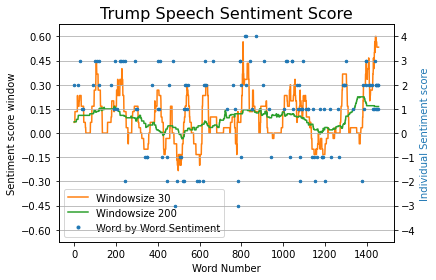

In [29]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sig1 = create_signal(window_size, stride, text_cleaned)
sig2 = zip(np.arange(len(sig1)),sig1)
sig3 = [tup for tup in sig2 if tup[1] != 0]
xs, ys = zip(*sig3)


ax1.plot(smoothing_filter(sign, 30), "-C1", label="Windowsize 30")
ax1.plot(smoothing_filter(sign, 200), "-C2", label="Windowsize 200")
ax1.plot(5,100,".C0", label="Word by Word Sentiment")
ax2.plot(xs, ys, ".C0", label="Word by Word Sentiment",markersize=5)

ax1.set_xlabel("Word Number")
ax1.set_ylabel("Sentiment score window")
ax2.set_ylabel("Individual Sentiment score", color="C0")
ax1.set_ylim([-0.675,0.675])
ax2.set_ylim([-4.5,4.5])
ax1.set_yticks(np.linspace(-0.6,0.6,9))
plt.title("Trump Speech Sentiment Score", fontsize=16)
#plt.xticks([-1000])
plt.grid(which='major')
ax1.legend(loc=3)
plt.show()

In [ ]:
#########################################################################################################
# Adapted from: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
# And https://pytorch.org/text/_modules/torchtext/datasets/text_classification.html
# And with inspiration from original adaptation by (presumably) Jonathan Foldager and (presumably) Hiba Nassar
#########################################################################################################

import numpy as np
import random
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import time
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import TextClassificationDataset
from torchtext.vocab import Vocab
from torchtext.vocab import build_vocab_from_iterator

#####################################################################################################################
# Auxilary functions
#####################################################################################################################

# Basic tokenizer, lowers text; splits by whitespace and special characters
tokenizer = get_tokenizer("basic_english")

def token_iterator(texts, ngrams):
    """
    Generator function, should be used to create a generator object
    of ngrams for each token in a given text
    """

    for text in texts:
        tokens = tokenizer(text)

        # Notice the yield keyword, rather than terminate the function like 'return' would, it 'yields' the object to a generator object
        yield ngrams_iterator(tokens, ngrams)


def construct_vocab(texts, ngrams: int):
    """
    Builds a torchtext.vocab.Vocab object from an iterable of texts
    Notice it also uses the token_iterator function, specified above above
    Basically a vocab is a like an ordered dictionary that holds occurance frequences of tokens
    So vocab[token] returns the number of occurences of that token
    Additionally, this token can be gated by frequency
    """
    vocab = build_vocab_from_iterator(token_iterator(texts, ngrams))
    return vocab


def text_to_tensor(text, vocab, ngrams):
    """
    Takes a single text and spits out a token vector (tensor)
    Possibly removes speical characters
    """

    # Get all tokens of a text
    tokens = ngrams_iterator(tokenizer(text), ngrams=ngrams)

    # Create a list, of simple token ids IFF the token is contained within the vocab
    # Perhaps wrong here, maybe Vocab.specials is the correct way to go
    token_ids = list(filter(lambda x: x is not Vocab.UNK, [vocab[token] for token in tokens]))

    # Create the glorious torch tensor from the tokens
    tokens = torch.tensor(token_ids)
    return tokens


def make_torchdataset(vocab, texts, labels, ngrams):
    # Tensonize each text in the texts dataset
    tokens = [text_to_tensor(text, vocab, ngrams) for text in tqdm(texts)]
    # Get label, token pairs
    # Remember labels are most likely a list whereas tokens are a list of a lists
    pairs = list(zip(labels, tokens))
    return TextClassificationDataset(vocab, pairs, set(labels))

def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

#####################################################################################################################
# Model
#####################################################################################################################


class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

#####################################################################################################################
# FastText
#####################################################################################################################


class FastText(object):

    def __init__(self, texts, labels, embed_dim, ngrams=3, num_epochs=0, seed=0):

        # set seed
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)


        self.texts = texts
        self.labels = labels
        self.embed_dim = embed_dim
        self.ngrams = ngrams

        # construct vocab
        print('Constructing vocabulary...')
        self.vocab = construct_vocab(texts, ngrams)
        self.vocab_size = len(self.vocab)

        # prepare dataset
        print('Preparing dataset...')
        self.train_dataset = make_torchdataset(self.vocab, texts, labels, ngrams)
        self.num_classes = len(self.train_dataset.get_labels())

        # prepare device ref and model
        self.device = torch.device("cpu")
        self.model = TextClassificationModel(self.vocab_size, self.embed_dim, self.num_classes).to(self.device)

        # loss function & optimization
        self.results = [].copy()
        self.epochs = 0
        self.criterion = torch.nn.CrossEntropyLoss().to(self.device)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=4.0)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
        self.batch_size = 16

        self.tokenizer = get_tokenizer("basic_english")
        self.ngrams = ngrams



        if num_epochs > 0:
            print('Training model...')
            self.train(self.train_dataset, num_epochs)


    def train_step(self, sub_train_):

        # Train the model
        train_loss = 0
        train_acc = 0
        data = DataLoader(sub_train_, batch_size=self.batch_size, shuffle=True, collate_fn=generate_batch)
        for i, (text, offsets, cls) in enumerate(data):
            self.optimizer.zero_grad()
            text, offsets, cls = text.to(self.device), offsets.to(self.device), cls.to(self.device)
            output = self.model(text, offsets)
            loss = self.criterion(output, cls)
            train_loss += loss.item()
            loss.backward()
            self.optimizer.step()
            train_acc += (output.argmax(1) == cls).sum().item()

        # Adjust the learning rate
        self.scheduler.step()

        return train_loss / len(sub_train_),  train_acc / len(sub_train_)

    def compute_loss(self, data_):
        loss = 0
        acc = 0
        data = DataLoader(data_, batch_size=self.batch_size, collate_fn=generate_batch)
        for text, offsets, cls in data:
            text, offsets, cls = text.to(self.device), offsets.to(self.device), cls.to(self.device)
            with torch.no_grad():
                output = self.model(text, offsets)
                loss = self.criterion(output, cls)
                loss += loss.item()
                acc += (output.argmax(1) == cls).sum().item()

        return loss / len(data_), acc / len(data_)

    def train(self, train_dataset, n_epochs=5):

        min_valid_loss = float('inf')

        for epoch in range(n_epochs):
            self.epochs += 1
            start_time = time.time()
            train_loss, train_acc  = self.train_step(train_dataset)

            secs = int(time.time() - start_time)
            mins = secs / 60
            secs = secs % 60

            test_results = [self.predict(text) for text in test_texts]
            test_acc = np.mean([test_results == test_labels])

            print('Epoch: %d' % (self.epochs), " | time in %d minutes, %d seconds" % (mins, secs))
            print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train), {test_acc * 100:.1f}%(test)')

            self.results.append([self.epochs,train_acc,test_acc,test_results])


        return self.results

    def predict(self, text_, return_prob=False):

        with torch.no_grad():
            text = text_to_tensor(text_, self.vocab, self.ngrams)
            output = self.model(text, torch.tensor([0]))

            if return_prob:
                return F.softmax(output, 1).detach().numpy()
            else:
                return output.argmax(1).item()

    def get_text_embedding(self, text_):
        with torch.no_grad():
            text = text_to_tensor(text_, self.vocab, self.ngrams)
            return self.model.embedding(text, offsets=torch.LongTensor([0])).detach().numpy()

    def word_in_vocab(self, word):
        return word in self.vocab.stoi





# Optional: multiply the sentiment-lexicon with a positive constant of your own choosing and comment on what effects it has on the sentiment analysis plot. 
